<a href="https://colab.research.google.com/github/lakshayae162/Project-1/blob/main/CNN_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
train_folder = '/content/drive/MyDrive/Project dataset/train'
test_folder =  '/content/drive/MyDrive/Project dataset/test'
validate_folder = '/content/drive/MyDrive/Project dataset/valid'

In [3]:
normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'

In [62]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from sklearn.metrics import log_loss

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

print("Libraries Imported")

Libraries Imported


In [39]:
# Read data from the folders
IMAGE_SIZE = (350, 350)

print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 8

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

Reading training images from: /content/drive/MyDrive/Project dataset/train
Reading validation images from: /content/drive/MyDrive/Project dataset/valid
Found 612 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.5, min_lr=0.000001)
early_stops = EarlyStopping(monitor='loss', min_delta=0, patience=6, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath='best_model.weights.h5', verbose=2, save_best_only=True, save_weights_only=True)


In [40]:
OUTPUT_SIZE = 4
inputs = Input(shape=(*IMAGE_SIZE, 3))

pretrained_model = Xception(weights='imagenet', include_top=False, input_tensor=inputs)
pretrained_model.trainable = False

#model = Sequential()
#model.add(pretrained_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(OUTPUT_SIZE, activation='softmax'))

x = GlobalAveragePooling2D()(pretrained_model.output)
outputs = Dense(OUTPUT_SIZE, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

print("Pretrained model used:")
pretrained_model.summary()

print("Final model created:")
model.summary()


Pretrained model used:


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 350, 350, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 174, 174, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 174, 174, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 174, 174, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 172, 172, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 172, 172, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 172, 172, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 172, 172, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 172, 172, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 172, 172, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 86, 86, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 86, 86, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

Final model created:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 350, 350, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 174, 174, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 174, 174, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 174, 174, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 172, 172, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 172, 172, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 172, 172, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 172, 172, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 172, 172, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 172, 172, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 86, 86, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 86, 86, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [41]:
# Compile the model for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
# Add EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [44]:
# Train CNN model on the dataset
model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 45s 416ms/step - accuracy: 0.2513 - loss: 1.4058 - val_accuracy: 0.4317 - val_loss: 1.2617
Epoch 2/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.4658 - loss: 1.2514 - val_accuracy: 0.5333 - val_loss: 1.1814
Epoch 3/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.5456 - loss: 1.1550 - val_accuracy: 0.5397 - val_loss: 1.1203
Epoch 4/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.5849 - loss: 1.0910 - val_accuracy: 0.5460 - val_loss: 1.0769
Epoch 5/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.5830 - loss: 1.0547 - val_accuracy: 0.5905 - val_loss: 1.0416
Epoch 6/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.5802 - loss: 1.0068 - val_accuracy: 0.5714 - val_loss: 1.0091
Epoch 7/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.6130 - loss: 0.9360 - val_accuracy: 0.5429 - val_loss: 0.9949
Epoch 8/40
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.6796 - loss: 0.9107 - val_accu

In [45]:
# Extract features and labels from training set
def extract_features(data_generator):
    features = []
    labels = []
    for inputs, label in data_generator:
        feature = model.predict(inputs)
        features.append(feature)
        labels.append(label)
        if len(features) >= data_generator.samples // batch_size:
            break
    return np.concatenate(features), np.concatenate(labels)

print("Extracting training features...")
train_features, train_labels = extract_features(train_generator)

print("Extracting validation features...")
validation_features, validation_labels = extract_features(validation_generator)

Extracting training features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━

In [46]:
# Flatten labels for SVM
train_labels = np.argmax(train_labels, axis=1)
validation_labels = np.argmax(validation_labels, axis=1)

In [47]:
# Train SVM on the extracted features
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features, train_labels)

SVC(kernel='linear', probability=True)

In [48]:
# Save SVM model
joblib.dump(svm_model, '/content/drive/MyDrive/Project dataset/svm_lung_cancer_model.joblib')

['/content/drive/MyDrive/Project dataset/svm_lung_cancer_model.joblib']

In [49]:
# Evaluate SVM model
val_predictions = svm_model.predict(validation_features)
val_accuracy = accuracy_score(validation_labels, val_predictions)
print(f"Validation Accuracy with CNN-SVM: {val_accuracy}")

Validation Accuracy with CNN-SVM: 0.6538461538461539


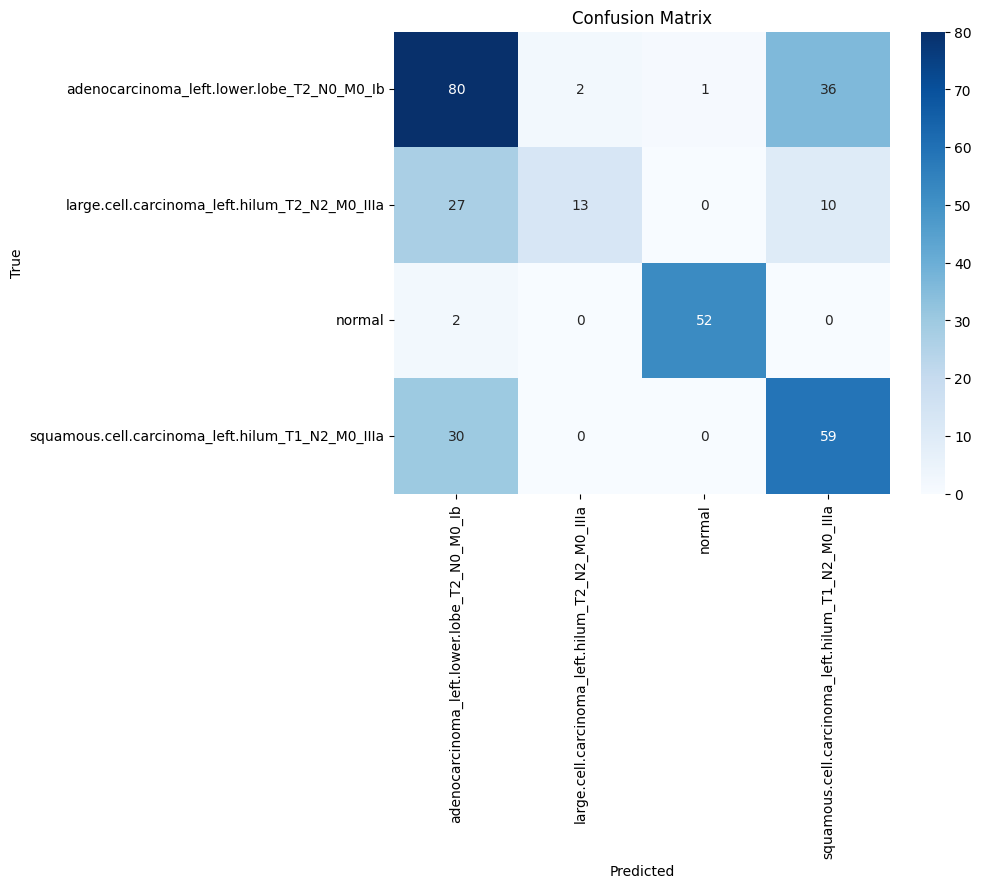

In [50]:
cm = confusion_matrix(validation_labels, val_predictions)
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [51]:
cr = classification_report(validation_labels, val_predictions)
# Display Classification Report
print("Classification Report:\n", cr)

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.67      0.62       119
           1       0.87      0.26      0.40        50
           2       0.98      0.96      0.97        54
           3       0.56      0.66      0.61        89

    accuracy                           0.65       312
   macro avg       0.75      0.64      0.65       312
weighted avg       0.69      0.65      0.64       312



In [66]:
# Evaluate SVM model
val_predictions = svm_model.predict(validation_features)
val_accuracy = accuracy_score(validation_labels, val_predictions)
print(f"Validation Accuracy with SVM: {val_accuracy}")

# Calculate log_loss for SVM (approximating loss)
val_probabilities = svm_model.predict_proba(validation_features)
validation_loss = log_loss(validation_labels, val_probabilities)
print(f"Validation Log Loss: {validation_loss}")


Validation Accuracy with SVM: 0.6538461538461539
Validation Log Loss: 0.8855682843189451


In [68]:
# Simulate multiple "epochs" of evaluation (for illustration purposes)
num_epochs = 5
accuracy_list = []
loss_list = []

# Run multiple evaluations with slight randomness or repeated evaluations
for epoch in range(num_epochs):
    val_predictions = svm_model.predict(validation_features)
    val_accuracy = accuracy_score(validation_labels, val_predictions)
    val_probabilities = svm_model.predict_proba(validation_features)
    validation_loss = log_loss(validation_labels, val_probabilities)

    accuracy_list.append(val_accuracy)
    loss_list.append(validation_loss)

# Simulated history for plotting
history = {
    'accuracy': accuracy_list,
    'val_accuracy': accuracy_list,  # We will use the same accuracy for both
    'loss': loss_list,
    'val_loss': loss_list  # Same for loss
}

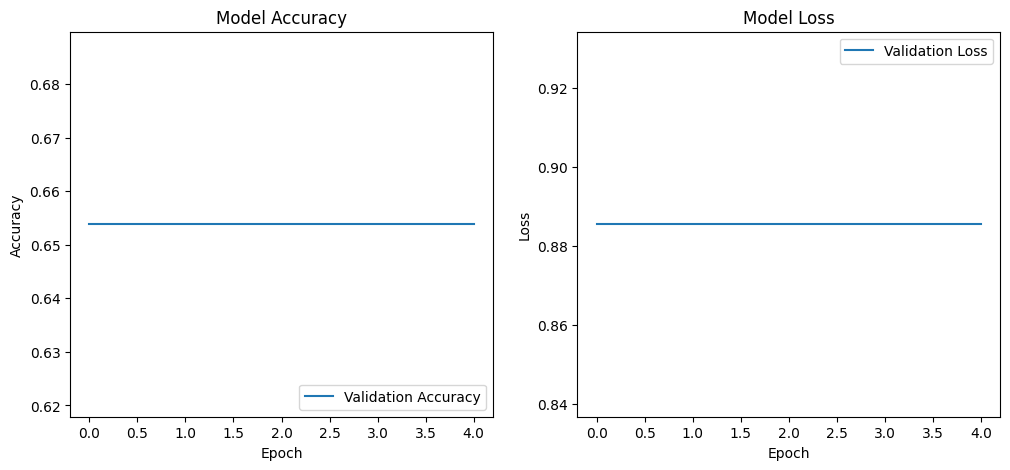

In [69]:
# Plot the accuracy and loss curves (for a single point here)
plt.figure(figsize=(12, 5))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [52]:
# Prediction function
def predict_image(img_path, cnn_model, svm_model):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Extract features with CNN model
    features = cnn_model.predict(img_array)
    features = features.reshape(1, -1)  # Flatten to 1D

    # Classify with SVM model
    predicted_class = svm_model.predict(features)
    predicted_label = list(train_generator.class_indices.keys())[predicted_class[0]]

    # Display the image with prediction
    plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
    return predicted_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


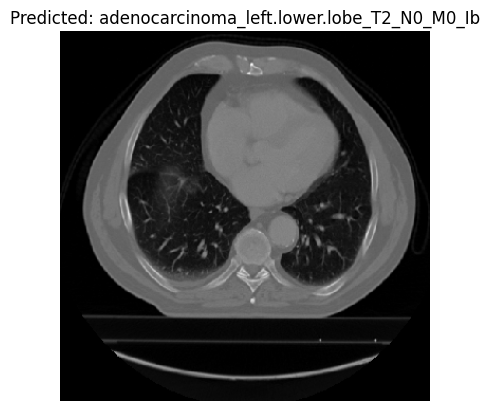

The image belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


In [53]:
#Prediction - Usage
img_path = '/content/drive/MyDrive/Project dataset/test/adenocarcinoma/000109 (5).png'  # Image path
predicted_label = predict_image(img_path, model, svm_model)
print(f"The image belongs to class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


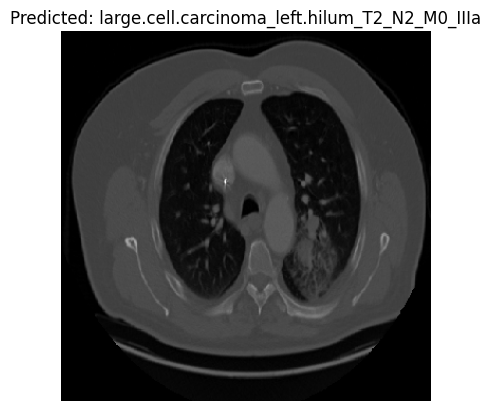

The image belongs to class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa


In [57]:
#Prediction - Usage
img_path = '/content/drive/MyDrive/Project dataset/test/large.cell.carcinoma/000154 (2).png'  # Image path
predicted_label = predict_image(img_path, model, svm_model)
print(f"The image belongs to class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


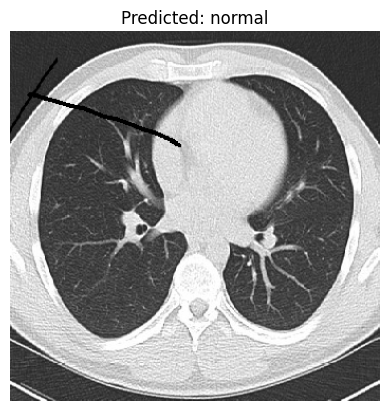

The image belongs to class: normal


In [58]:
#Prediction - Usage
img_path = '/content/drive/MyDrive/Project dataset/test/normal/11 (2).png'  # Image path
predicted_label = predict_image(img_path, model, svm_model)
print(f"The image belongs to class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


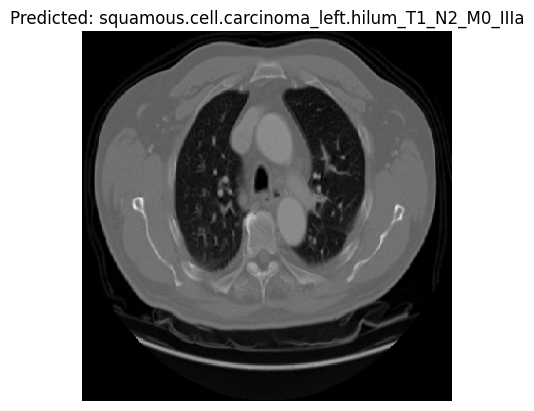

The image belongs to class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


In [61]:
#Prediction - Usage
img_path = '/content/drive/MyDrive/Project dataset/test/squamous.cell.carcinoma/000129 (6).png'  # Image path
predicted_label = predict_image(img_path, model, svm_model)
print(f"The image belongs to class: {predicted_label}")